reference: [COVID-19 Screening From Audio | Part 1](https://www.kaggle.com/code/nasrulhakim86/covid-19-screening-from-audio-part-1)

In [ ]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

import seaborn as sns
sns.set_palette(sns.color_palette("GnBu_r"))
import matplotlib.pyplot as plt
from IPython import display

In [13]:
# set variables
ROOT = 'F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/'

# load coughvid meta
data_raw = pd.read_csv(ROOT+'metadata_compiled.csv', index_col=0, header=0)
data_raw.head(3)

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,48.9,2.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,31.3,34.8,15.0,male,False,False,healthy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,NaN,NaN,46.0,female,False,False,healthy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


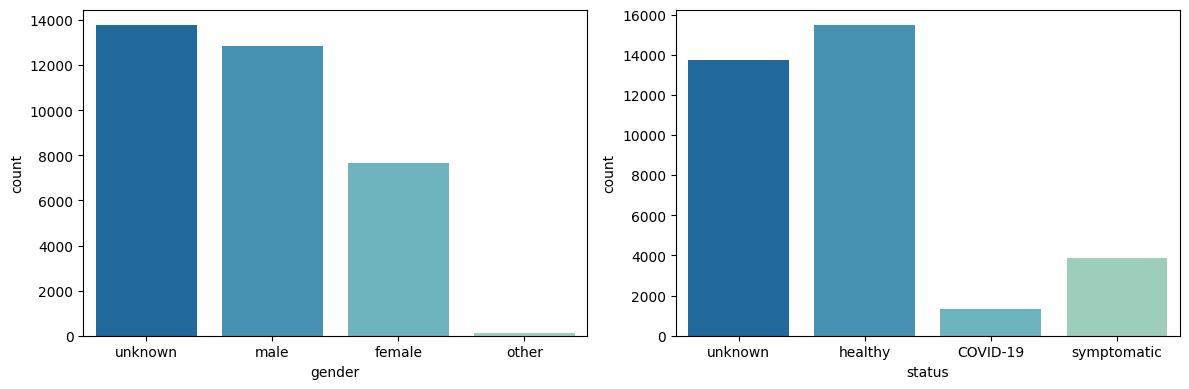

In [14]:
data_full = data_raw.fillna('unknown')
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=data_full, x="gender", ax=axs[0])
sns.countplot(data=data_full, x="status", ax=axs[1])
f.tight_layout()

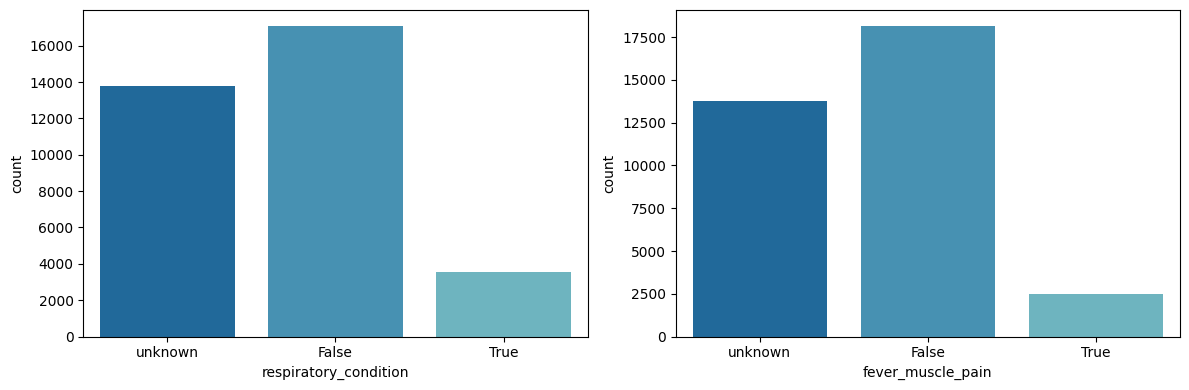

In [15]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=data_full, x="respiratory_condition", ax=axs[0])
sns.countplot(data=data_full, x="fever_muscle_pain", ax=axs[1])
f.tight_layout()

C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


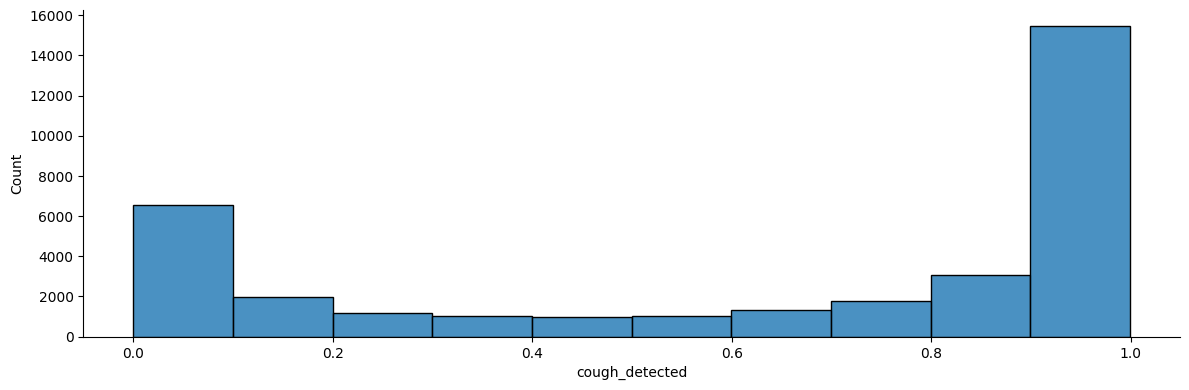

In [16]:
sns.displot(data_full, x="cough_detected", bins=10, height=4, aspect=3)

In [17]:
def split_by_physicians(df):
    column_names = ['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude', 
                    'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status', 
                    'quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 
                    'congestion', 'nothing', 'diagnosis', 'severity' ]
    physician_01 = df.iloc[:, 0:21]
    physician_01 = physician_01[physician_01.quality_1.notna()].reset_index(drop=True)
    physician_01.columns = column_names
    physician_01['physician'] = 'P01'

    physician_02 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 21:31]], axis=1)
    physician_02 = physician_02[physician_02.quality_2.notna()].reset_index(drop=True)
    physician_02.columns = column_names
    physician_02['physician'] = 'P02'

    physician_03 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 31:41]], axis=1)
    physician_03 = physician_03[physician_03.quality_3.notna()].reset_index(drop=True)
    physician_03.columns = column_names
    physician_03['physician'] = 'P03'

    physician_04 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 41:51]], axis=1)
    physician_04 = physician_04[physician_04.quality_4.notna()].reset_index(drop=True)
    physician_04.columns = column_names
    physician_04['physician'] = 'P04'
    return physician_01, physician_02, physician_03, physician_04

physician_01, physician_02, physician_03, physician_04 = split_by_physicians(data_raw)
annotated_df = pd.concat([physician_01,physician_02,physician_03,physician_04]).reset_index(drop=True)
annotated_df = annotated_df.fillna('unknown')
annotated_df.head(3)

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity,physician
0,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22T10:24:21.408615+00:00,0.2677,unknown,unknown,28.0,male,True,True,symptomatic,...,dry,False,False,False,False,False,True,healthy_cough,pseudocough,P01
1,01208e5c-5338-4f1b-b8c6-41c049e40d90,2020-04-12T17:13:03.918683+00:00,0.9968,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,dry,False,False,False,False,False,True,lower_infection,mild,P01
2,01567151-7bb2-45ee-9aa8-a1332b5941ea,2020-04-14T15:22:08.514166+00:00,0.9820,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,dry,False,False,False,True,False,False,COVID-19,mild,P01


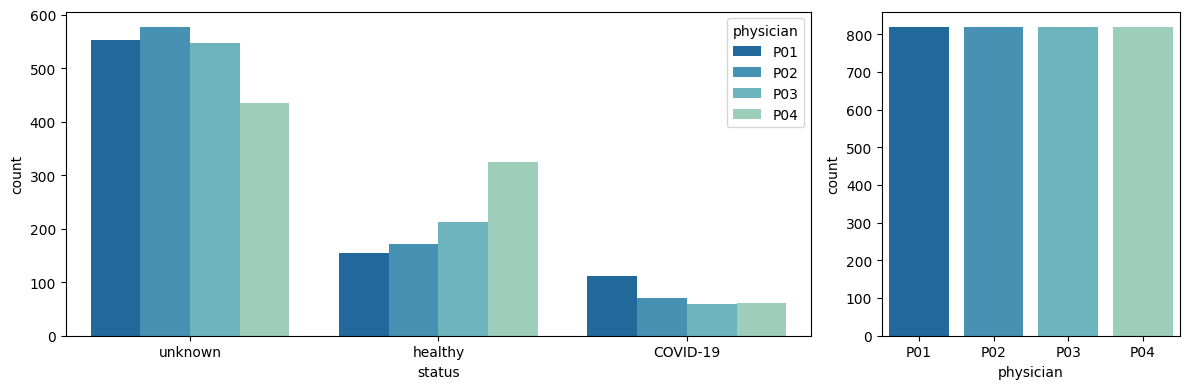

In [18]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[10, 4]))
sns.countplot(data=annotated_df, x="status", hue='physician', ax=axs[0])
sns.countplot(data=annotated_df, x="physician", ax=axs[1])
f.tight_layout()

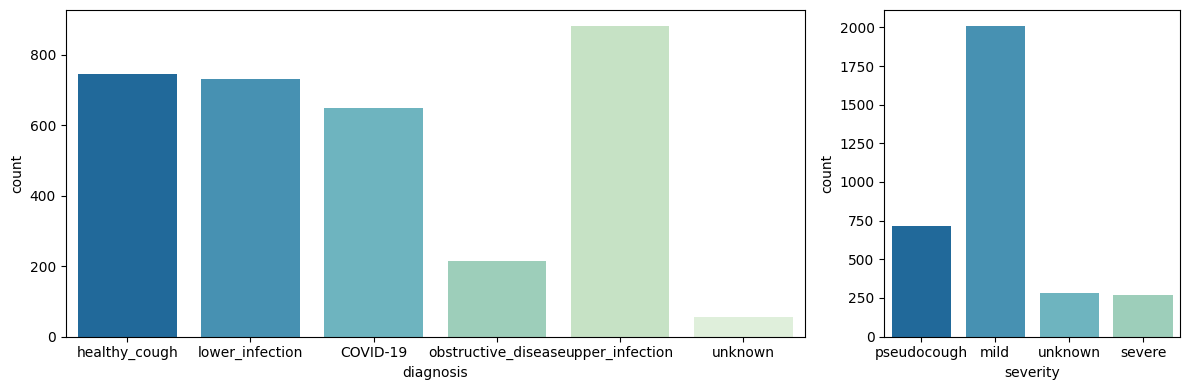

In [19]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[10, 4]))
sns.countplot(data=annotated_df, x="diagnosis", ax=axs[0])
sns.countplot(data=annotated_df, x="severity", ax=axs[1])
f.tight_layout()

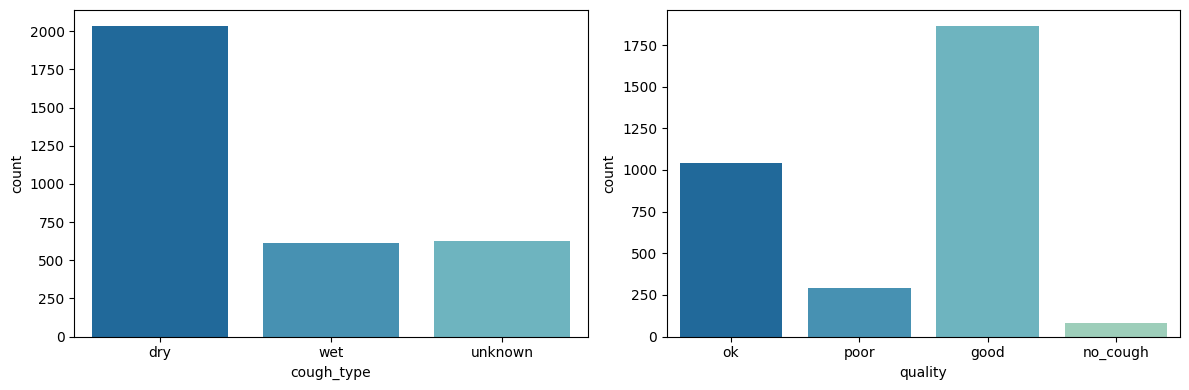

In [20]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="cough_type", ax=axs[0])
sns.countplot(data=annotated_df, x="quality", ax=axs[1])
f.tight_layout()

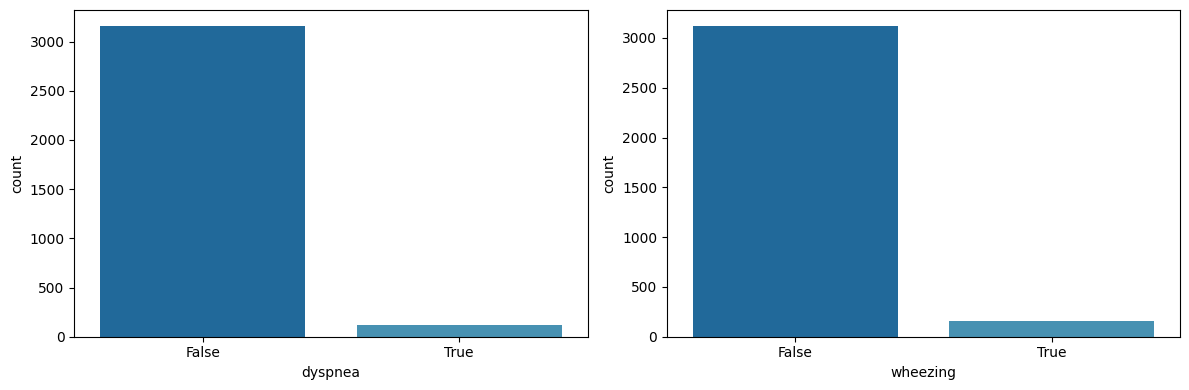

In [21]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="dyspnea", ax=axs[0])
sns.countplot(data=annotated_df, x="wheezing", ax=axs[1])
f.tight_layout()

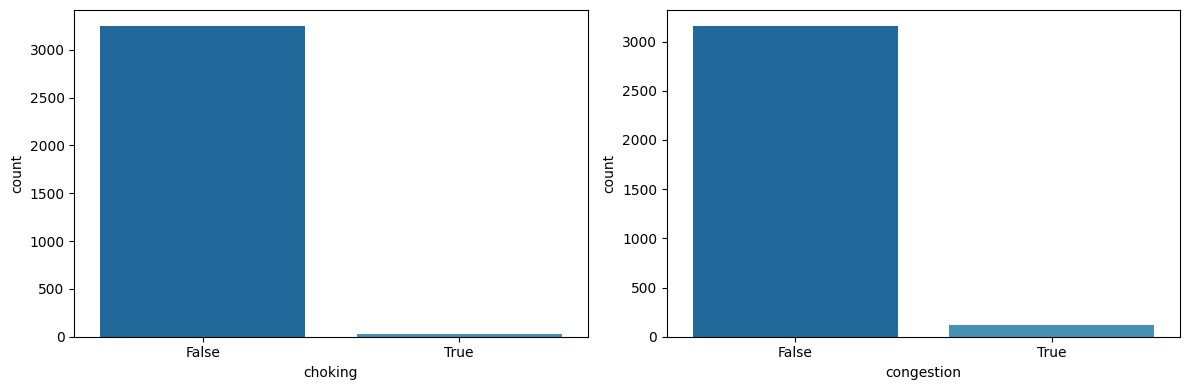

In [22]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.countplot(data=annotated_df, x="choking", ax=axs[0])
sns.countplot(data=annotated_df, x="congestion", ax=axs[1])
f.tight_layout()

## Audio data examples

C:\Users\zhaoke\AppData\Local\Temp\ipykernel_11604\1112356933.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  healthy_audio, fs = librosa.load(healthy_sample, mono=True)
C:\Users\zhaoke\AppData\Local\Temp\ipykernel_11604\1112356933.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  covid_audio, fs = librosa.load(covid_sample, mono=True)
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\zhaoke\AppData\Local\Temp\ipykernel_11604\1112356933.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  symptomatic_audio, fs = librosa.load(symptomatic_sample, mono=True)


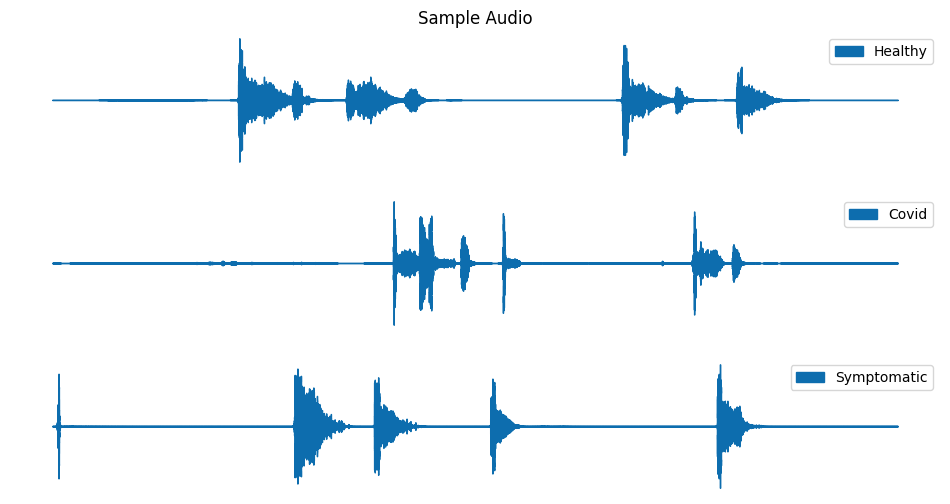

In [25]:
healthy_sample = ROOT+data_raw[data_raw.uuid == 'a28776b5-b876-47ac-8973-9ca280156608'].uuid.values[0]+'.webm'
covid_sample = ROOT+data_raw[data_raw.uuid == 'ffbca476-8b35-4797-bc8a-b7f0a2f24b55'].uuid.values[0]+'.webm'
symptomatic_sample = ROOT+data_raw[data_raw.uuid == '6d8fcfb2-7aff-4143-a319-99d568035655'].uuid.values[0]+'.webm'
healthy_audio, fs = librosa.load(healthy_sample, mono=True)
covid_audio, fs = librosa.load(covid_sample, mono=True)
symptomatic_audio, fs = librosa.load(symptomatic_sample, mono=True)

fig, (ax, ax1, ax2) = plt.subplots(nrows=3, figsize=(12,6))
ax.set(title='Sample Audio')
librosa.display.waveshow(healthy_audio, sr=fs, ax=ax, label='Healthy')
librosa.display.waveshow(covid_audio, sr=fs, ax=ax1, label='Covid')
librosa.display.waveshow(symptomatic_audio, sr=fs,  ax=ax2, label='Symptomatic')
ax.axis('off')
ax.label_outer()
ax.legend()
ax1.axis('off')
ax1.label_outer()
ax1.legend()
ax2.axis('off')
ax2.label_outer()
ax2.legend()

# Feature

In [26]:
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter, filtfiltm, cwtm, hilbert
from scipy.signal import resamplem, decimatem, spectrogram
from scipy.signal.windows import get_window

In [27]:
def preprocess_cough(x,fs, cutoff = 6000, normalize = True, filter_ = True, downsample = True):
    # Normalize, lowpass filter, and downsample cough samples in a given data folder 
    fs_downsample = cutoff*2
    
    #Preprocess Data
    if len(x.shape)>1:
        x = np.mean(x,axis=1)                          # Convert to mono
    if normalize:
        x = x/(np.max(np.abs(x))+1e-17)                # Norm to range between -1 to 1
    if filter_:
        b, a = butter(4, fs_downsample/fs, btype='lowpass') # 4th order butter lowpass filter
        x = filtfilt(b, a, x)
    if downsample:
        x = signal.decimate(x, int(fs/fs_downsample)) # Downsample for anti-aliasing
    
    fs_new = fs_downsample
    return np.float32(x), fs_new

def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    #Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power       
    cough_mask = np.array([False]*len(x))
    
    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

(-4035.1000000000004, 84737.1, -0.9297379672527313, 1.091892284154892)

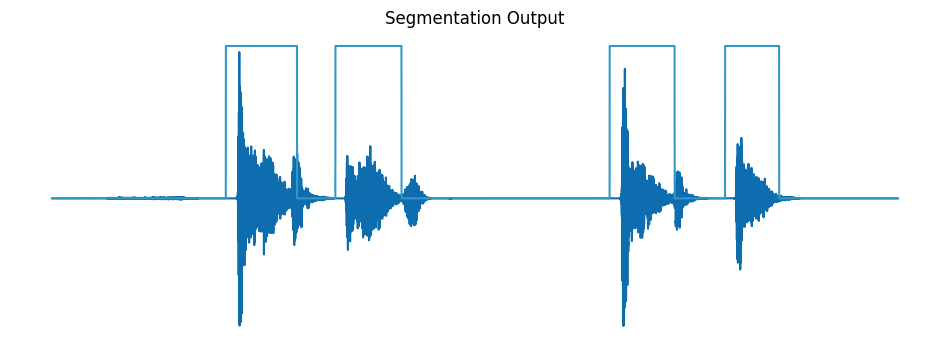

In [28]:
# Preprocess (Normalize, lowpass filter, and downsample cough samples)
processed_audio, sample_rate = preprocess_cough(healthy_audio, fs)

# Segment each audio into individual coughs using a hysteresis comparator on the signal power
cough_segments, cough_mask = segment_cough(processed_audio, sample_rate, min_cough_len=0.1, cough_padding=0.1, th_l_multiplier = 0.1, th_h_multiplier = 2)

fig = plt.figure(figsize=(12,4))
plt.plot(processed_audio)
plt.plot(cough_mask)
plt.title("Segmentation Output")
plt.axis('off')

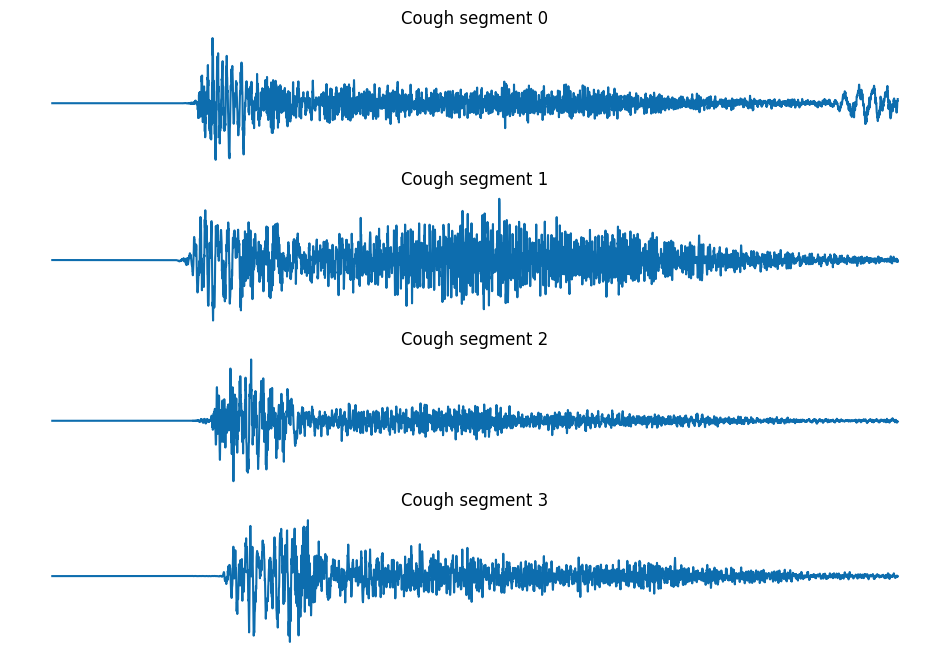

In [29]:
fig, axs = plt.subplots(len(cough_segments),1, figsize=(12,8))
for i in range(0,len(cough_segments)):
    axs[i].plot(cough_segments[i])
    axs[i].set_title("Cough segment " + str(i))
    axs[i].axis('off')

In [ ]:
# first segment healthy sample
display.Audio(cough_segments[0], rate=fs)

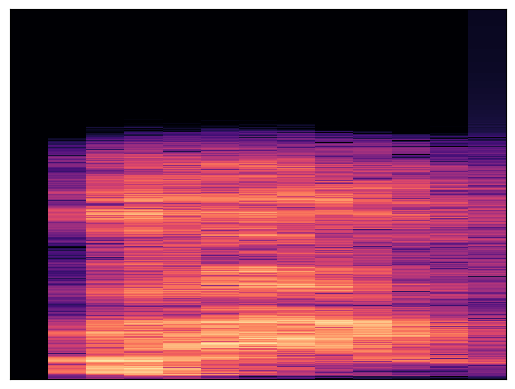

In [30]:
# Short Term Fourier Transform
audio_data = cough_segments[1]
stft = np.abs(librosa.stft(audio_data))
Dstft = librosa.amplitude_to_db(stft, ref=np.max)
ax = librosa.display.specshow(Dstft)

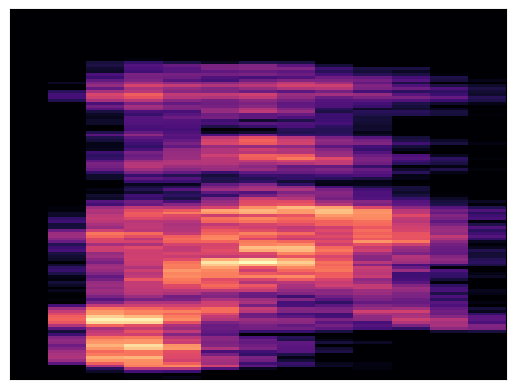

In [35]:
# compute a mel-scaled spectrogram.
mel = librosa.feature.melspectrogram(y=audio_data, sr=fs)  # 必须按照key值，不能用位置参数
Dmel = librosa.amplitude_to_db(mel, ref=np.max)
ax = librosa.display.specshow(Dmel)

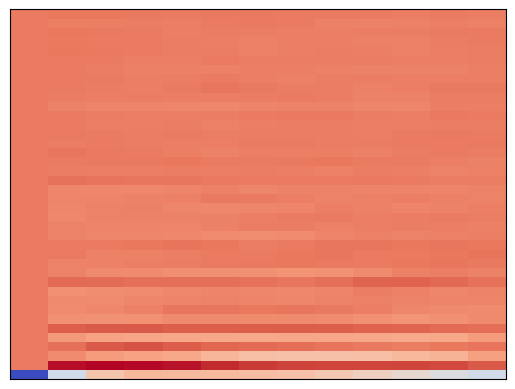

In [36]:
# mel-frequency cepstral coefficients (MFCCs)
mfcc = librosa.feature.mfcc(y=audio_data, sr=fs, n_mfcc=40)
ax = librosa.display.specshow(mfcc)

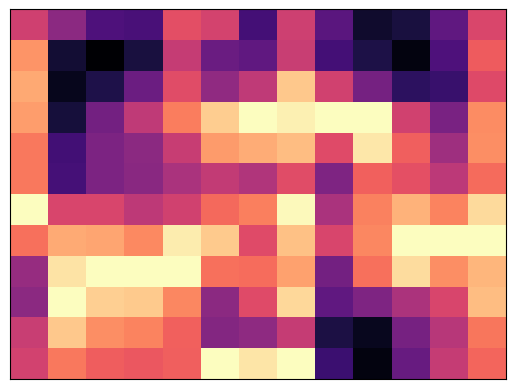

In [37]:
# compute a chromagram from a waveform or power spectrogram.
chroma = librosa.feature.chroma_stft(S=stft, sr=fs)
ax = librosa.display.specshow(chroma)

# End